<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%203/Case_Study_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install beautifulsoup4
!pip install scikit-learn-intelex

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -l /content/drive/MyDrive/SpamAssassinMessages/

total 20
drwx------ 2 root root 4096 Jun  6 01:24 easy_ham
drwx------ 2 root root 4096 Jun  6 01:24 easy_ham_2
drwx------ 2 root root 4096 Jun  6 01:24 hard_ham
drwx------ 2 root root 4096 Jun  6 01:24 spam
drwx------ 2 root root 4096 Jun  6 01:24 spam_2


In [5]:
from gensim.parsing.preprocessing import STOPWORDS
from nltk import word_tokenize
import os, chardet, email
import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from nltk.corpus import stopwords
import nltk; nltk.download('popular')
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [6]:
file_list = []
for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/", topdown=False):
    for name in files:
        tmp = os.path.join(root,name)
        file_list.append(tmp)
    for item in dirs:
        print(item)
i=0

file_list_full = []
while i < len(file_list):
    file_list_full.append(file_list[i])
    i+=1

spam_2
spam
easy_ham_2
easy_ham
hard_ham


In [7]:
len(file_list_full)

9353

In [9]:
%%capture
contents = []
types = []
labels = []
sender = []

i = 0

for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/"):
    for name in files:
        blob = open(os.path.join(root, name), 'rb').read()

        # Determining the encoding of the email
        result = chardet.detect(blob)
        encoding_dynamic = result['encoding']

        with open(os.path.join(root, name), 'rb') as f:
            decoded_email = f.read().decode(encoding_dynamic, errors='replace')
            
            x = email.message_from_string(decoded_email)
            print('normal', os.path.join(root, name))
            i += 1

            #adding in the sender's domain as a new column
            sender_raw = x.get('From')
            if sender_raw:
                sender_domain = sender_raw.split('@')[-1]
                if sender_domain:
                    sender.append(sender_domain)
                else:
                    sender.append("missing")
            else:
                sender.append("missing")


            if "multipart" in x.get_content_type():
                content_parts = []
                for part in x.walk():
                    if part.get_content_type() == "text/plain":
                        decoded_part = part.get_payload(decode=True).decode(encoding_dynamic, errors='replace')
                        content_parts.append(decoded_part.replace("\n", " "))
                    elif part.get_content_type() == "text/html":
                        soup = BeautifulSoup(part.get_payload(decode=True).decode(encoding_dynamic, errors='replace'), 'html.parser')
                        decoded_part = soup.get_text().replace("\n", " ")
                        content_parts.append(decoded_part)
                content = "\n".join(content_parts)
                contents.append(content)
                types.append(x.get_content_type())

            elif "text/plain" in x.get_content_type():
                decoded_content = x.get_payload(decode=True).decode(encoding_dynamic, errors='replace')
                contents.append(decoded_content.replace("\n", " "))
                types.append(x.get_content_type())

            elif "text/html" in x.get_content_type():
                soup = BeautifulSoup(x.get_payload(decode=True).decode(encoding_dynamic, errors='replace'), 'html.parser')
                decoded_content = soup.get_text().replace("\n", " ")
                contents.append(decoded_content)
                types.append(x.get_content_type())

            if "ham" in root:
                labels.append(0)
            elif "spam" in root:
                labels.append(1)
            else:
                print("YOU HAVE A BIG PROBLEM -- LABEL NOT FOUND")


In [10]:
print('contents length: ', len(contents))
print('types length: ', len(types))
print('labels length: ', len(labels))
print('file list length: ', len(file_list_full))
print('sender length: ', len(sender))

contents length:  9353
types length:  9353
labels length:  9353
file list length:  9353
sender length:  9353


In [11]:
# Encode the contents array to utf-8, before it gets added to pandas dataframe
encoded_contents = [content.encode('utf-8', errors='replace') for content in contents]

In [12]:
data = pd.DataFrame({"Text":encoded_contents,"Label":labels, "Type":types, "Filename": file_list_full, "Sender": sender})
data

,Text,Label,Type,Filename,Sender
0,"b""SUBJECT: Urgent Concern ...",1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...,writeme.com>
1,b' \xc2\xa0 You can\'t predic...,1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...,personal.ro>
2,"b'As seen on NBC, CBS, CNN, and even Oprah! Th...",1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...,mail.com
3,b' Thanks ...,1,multipart/mixed,/content/drive/MyDrive/SpamAssassinMessages/sp...,dogma.slashnull.org>
4,b' \xc2\xa0 Dear ...,1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...,263.net>
...,...,...,...,...,...
9348,"b'Hi XFS developers, When studying xfs code(2....",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...,mountainviewdata.com>
9349,"b""My gut reaction would be to tell them to go ...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...,eircom.net>
9350,b' * WORD A DAY * -------...,0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...,shagmail.com>
9351,"b""============================================...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...,daytips.com>


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      9353 non-null   object
 1   Label     9353 non-null   int64 
 2   Type      9353 non-null   object
 3   Filename  9353 non-null   object
 4   Sender    9353 non-null   object
dtypes: int64(1), object(4)
memory usage: 365.5+ KB


In [14]:
data['Text'] = data['Text'].astype('|S') # which will by default set the length to the max len it encounters
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      9353 non-null   |S202500
 1   Label     9353 non-null   int64   
 2   Type      9353 non-null   object  
 3   Filename  9353 non-null   object  
 4   Sender    9353 non-null   object  
dtypes: bytes1620000(1), int64(1), object(3)
memory usage: 1.8+ GB


In [15]:
data['Label'].value_counts() #distribution of spam/ham

0    6954
1    2399
Name: Label, dtype: int64

In [16]:
stop = list(stopwords.words('english'))
#to add additional words to stop words
#stop.extend('myword1 myword2 myword3'.split())

# MultiNB
X = data['Text']
y = data['Label'].values

skf = StratifiedKFold(n_splits=10,random_state=610,shuffle=True)
skf.get_n_splits(X,y)

#need to vectorize within pipeline to prevent data leakage (otherwise tfidf would be fitted over all the data)
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB())
])
pipe_params = {
    'estimator__alpha':[.01,.05,.1]
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator', MultinomialNB(alpha=0.01))])
0.9928367384249738


In [17]:
results_df=pd.DataFrame(results.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,15.784020,1.409048,0.897258,0.069355,0.01,{'estimator__alpha': 0.01},0.995726,0.990385,0.990385,0.996791,0.990374,0.989305,0.995722,0.994652,0.992513,0.992513,0.992837,0.002577,1
1,13.667904,0.552776,0.961065,0.123691,0.05,{'estimator__alpha': 0.05},0.991453,0.988248,0.983974,0.997861,0.989305,0.989305,0.990374,0.991444,0.993583,0.989305,0.990485,0.003427,2
2,12.847022,1.861026,0.848880,0.171408,0.1,{'estimator__alpha': 0.1},0.989316,0.986111,0.980769,0.996791,0.983957,0.982888,0.988235,0.990374,0.991444,0.987166,0.987705,0.004413,3


In [18]:
stop = list(stopwords.words('english'))
#to add additional words to stop words
#stop.extend('myword1 myword2 myword3'.split())

skf = StratifiedKFold(n_splits=10,random_state=610,shuffle=True)
skf.get_n_splits(X,y)

#need to vectorize within pipeline to prevent data leakage (otherwise tfidf would be fitted over all the data)
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB())
])
pipe_params = {
    'estimator__alpha':[.01,.05,.1]
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='recall',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator', MultinomialNB(alpha=0.01))])
0.9791562064156206


In [39]:
#running model on messages
X = data['Text']
y = data['Label'].values

# MultiNB with best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB(alpha=results.best_params_.get('estimator__alpha')))
])
acc_score = []
rec_score = []
feature_names = []

for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))

    #feature importance by word
    feature_log_probs = my_pipe.named_steps['estimator'].feature_log_prob_
    feature_names = my_pipe.named_steps['vectorizer'].get_feature_names_out()


# Convert feature log probabilities to probabilities
feature_probs = np.exp(feature_log_probs)

# Create a DataFrame to store feature importance
feature_probability = pd.DataFrame({'Feature': feature_names,
                                   'Probability': feature_probs[1]})

# Sort feature importance by importance score
feature_probability = feature_probability.sort_values(by='Probability', ascending=False)


# saving scores for comparison    
mNB_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       1.00      0.99      0.99       240

    accuracy                           1.00       936
   macro avg       1.00      0.99      0.99       936
weighted avg       1.00      1.00      1.00       936

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       696
           1       0.99      0.97      0.98       240

    accuracy                           0.99       936
   macro avg       0.99      0.99      0.99       936
weighted avg       0.99      0.99      0.99       936

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       696
           1       0.99      0.97      0.98       240

    accuracy                           0.99       936
   macro avg       0.99      0.98      0.99       936
weighted avg       0.99      0.99      0.99       936

              preci

In [40]:
mNB_scores

,accuracy,recall
0,0.995726,0.987500
1,0.990385,0.975000
2,0.990385,0.970833
3,0.996791,0.987500
4,0.990374,0.979167
5,0.989305,0.970833
6,0.995722,0.987500
7,0.994652,0.983333
8,0.992513,0.975000
9,0.992513,0.974895


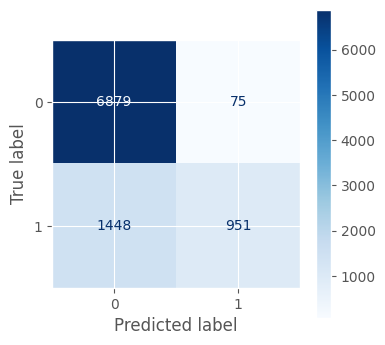

In [61]:
plt.rcParams["figure.figsize"] = (4,4)
ConfusionMatrixDisplay.from_predictions(y,my_pipe.predict(X),cmap='Blues')

[Text(0.5, 1.0, 'Top Email keywords by Probability')]

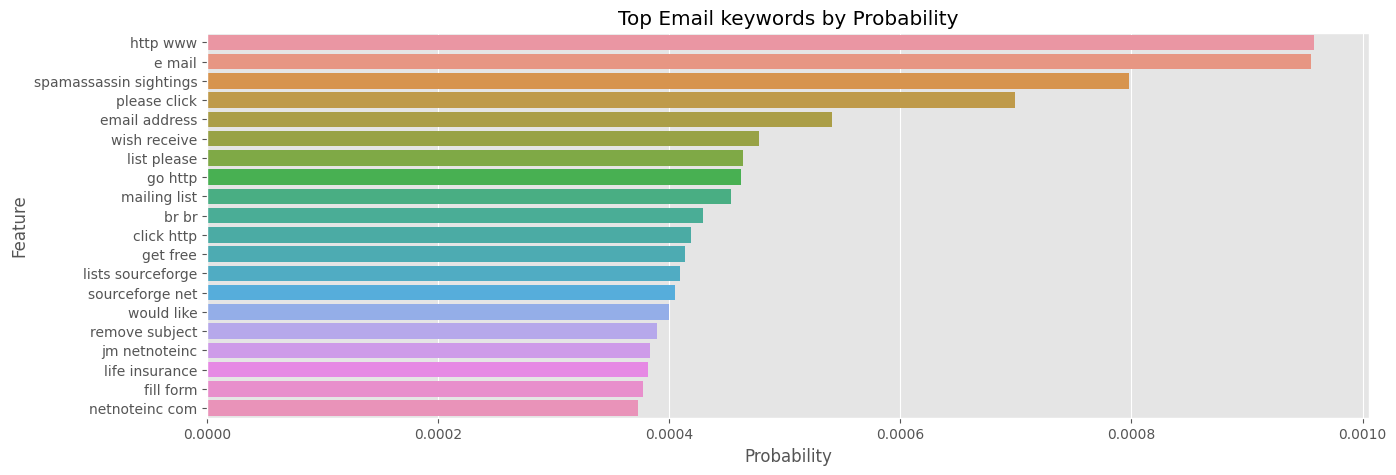

In [24]:
idx = feature_probability['Probability'].abs().sort_values(ascending = False).head(20).index
feature_probability2 = feature_probability.loc[idx]

plt.style.use('ggplot')
plt.figure(figsize = (15,5))
sns.barplot(x='Probability',y='Feature',data=feature_probability2).set(title='Top Email keywords by Probability')

In [42]:
#rerunning model on Sender Domain
X = data['Sender']
y = data['Label'].values

# MultiNB with best params
domain_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB(alpha=results.best_params_.get('estimator__alpha')))
])
acc_score = []
rec_score = []
feature_names = []

for i, (train,test) in enumerate(skf.split(X,y)):
    domain_pipe.fit(X[train],y[train])
    p = domain_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))

    #feature importance by word
    feature_log_probs = domain_pipe.named_steps['estimator'].feature_log_prob_
    feature_names = domain_pipe.named_steps['vectorizer'].get_feature_names_out()


# Convert feature log probabilities to probabilities
feature_probs = np.exp(feature_log_probs)

# Create a DataFrame to store feature importance
feature_probability = pd.DataFrame({'Feature': feature_names,
                                   'Probability': feature_probs[1]})

# Sort feature importance by importance score
feature_probability = feature_probability.sort_values(by='Probability', ascending=False)


# saving scores for comparison    
mNB_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       696
           1       0.92      0.85      0.88       240

    accuracy                           0.94       936
   macro avg       0.94      0.91      0.92       936
weighted avg       0.94      0.94      0.94       936

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       696
           1       0.85      0.83      0.84       240

    accuracy                           0.92       936
   macro avg       0.90      0.89      0.90       936
weighted avg       0.92      0.92      0.92       936

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       696
           1       0.87      0.82      0.85       240

    accuracy                           0.92       936
   macro avg       0.90      0.89      0.90       936
weighted avg       0.92      0.92      0.92       936

              preci

[Text(0.5, 1.0, 'Top Sender Domains by Probability')]

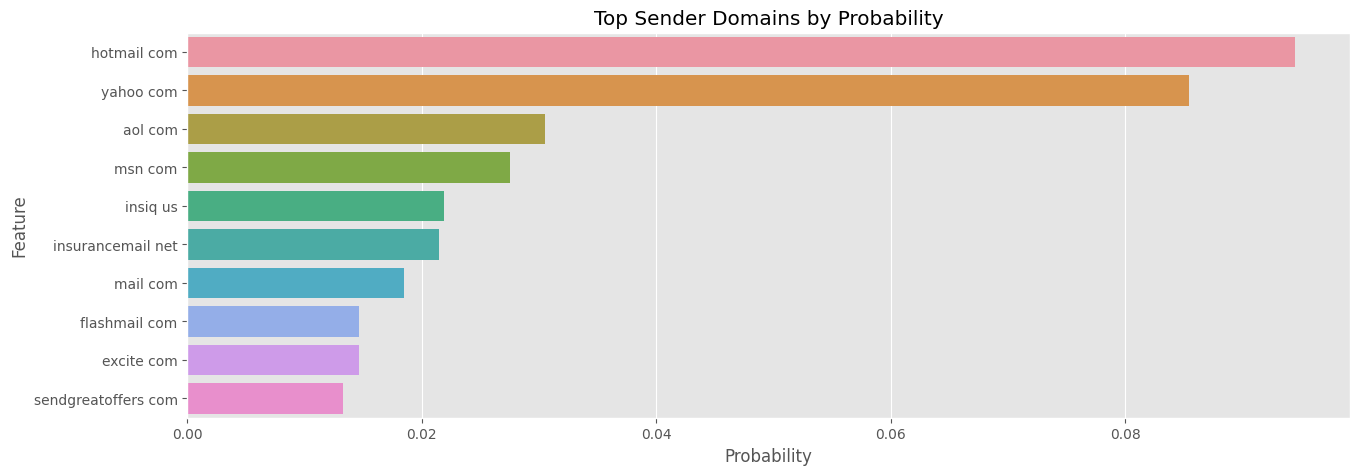

In [31]:
idx = feature_probability['Probability'].abs().sort_values(ascending = False).head(10).index
feature_probability2 = feature_probability.loc[idx]

plt.style.use('ggplot')
plt.figure(figsize = (15,5))
sns.barplot(x='Probability',y='Feature',data=feature_probability2).set(title='Top Sender Domains by Probability')

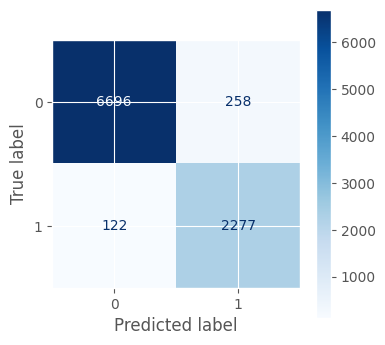

In [62]:
plt.rcParams["figure.figsize"] =  (4,4)
ConfusionMatrixDisplay.from_predictions(y,domain_pipe.predict(X),cmap='Blues')

In [ ]:
# support vector machine - classifier
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',SVC(random_state=610))
])
pipe_params = {
    'estimator__C':[.01,.1,.5,1],
    'estimator__gamma':['scale','auto']
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator', SVC(C=1, random_state=610))])
0.9868491475844416


In [ ]:
# svc with best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',SVC(random_state=610,C=results.best_params_.get('estimator__C')))#not returning best for gamma for some reason
])
acc_score = []
rec_score = []
for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))
    
svc_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       696
           1       1.00      0.96      0.98       240

    accuracy                           0.99       936
   macro avg       0.99      0.98      0.98       936
weighted avg       0.99      0.99      0.99       936

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       696
           1       0.99      0.95      0.97       240

    accuracy                           0.99       936
   macro avg       0.99      0.97      0.98       936
weighted avg       0.99      0.99      0.98       936

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       696
           1       0.99      0.96      0.97       240

    accuracy                           0.99       936
   macro avg       0.99      0.98      0.98       936
weighted avg       0.99      0.99      0.99       936

              preci

In [ ]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier


my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',RandomForestClassifier(random_state=610,max_depth = 100))
])
pipe_params = {
    'estimator__n_estimators':[50,100,200],
    'estimator__class_weight':['balanced',None]
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

In [ ]:
# rf best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',RandomForestClassifier(max_detph = 100,
                                        random_state=610,
                                        n_estimators = results.best_params.get('n_estimators'),
                                        class_weight = results.best_params.get('class_weight')))
])
acc_score = []
rec_score = []
for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))
    
rf_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})

In [ ]:
# clustering
## checking to see if KMeans can find two clusters that match fairly well with target

from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=2,n_init='auto',random_state=610).fit(X)
km_labels = clustering.labels_


In [ ]:
# clustering
from sklearn.cluster import DBSCAN #DBSCAN works with

clustering = DBSCAN(eps=1,n_jobs=-1).fit(X)
db_labels = clustering.labels_

In [ ]:
reverse={}
for word,value in word_counts.vocabulary_.items():
    reverse[value]=word